In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm

from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import *
from models import *
from utils import *

# torch._dynamo.config.suppress_errors = True

Load dataset:

In [15]:
data_size = 1000000
data_gen = FeatureRandomRing3(N=32)
X, y = data_gen.generate_dataset(data_size=data_size, noise=True, sigma=0.3, features_degree=2, seed=42, device='cpu', test_return=True)
data_gen.noise_delta

{'mse_loss': {'mean': 0.010259420610964298, 'std': 0.00042792316526174545},
 'l1_loss': {'mean': 0.08140861243009567, 'std': 0.0018837638199329376}}

[[13.         11.          8.90931     1.036052    0.8420027   0.08427981]
 [ 9.          9.          8.184581    1.1812047   0.3102652   0.22517234]
 [10.         14.          8.260114    1.0568107   3.4546118   0.16551465]
 ...
 [10.         13.          8.876792    1.38974     0.841757    0.03283554]
 [12.         12.          7.159465    1.1992157   4.868433    0.42001247]
 [13.         14.          6.379924    1.5157822   1.1777085   0.29163417]]
[[0.         0.71428571 0.42857143 ... 0.01795845 0.02259617 0.02841242]
 [0.         0.14285714 0.14285714 ... 0.00243842 0.0222457  0.20281086]
 [0.         0.28571429 0.85714286 ... 0.30230151 0.18206882 0.10958068]
 ...
 [0.         0.28571429 0.71428571 ... 0.01794797 0.00880086 0.0043127 ]
 [0.         0.57142857 0.57142857 ... 0.6003717  0.65110569 0.70564376]
 [0.         0.71428571 0.85714286 ... 0.03513318 0.10936439 0.34020285]]


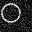

In [16]:
features, transformed_features, imgs = data_gen.random_sample(256)
print(features)
print(transformed_features)
Image.fromarray(abs(imgs[0].reshape((32, 32)) * 255 / imgs[0].max()).astype(np.uint8))

Test generator:

In [17]:
# load generator
generator = DGBaNConv17()
# generator = torch.compile(generator)

pre_trained_weights = torch.load(
    '../save_data/FeatureRandomRing3/Adam_mse_loss_0/DGBaNConv17_no_activation_function/DGBaNConv17_no_activation_function_73.pt',
    map_location=torch.device('cpu')
)
generator.load_state_dict(pre_trained_weights)

print(generator.eval())
print(f'Number of parameters: {count_params(generator):,}')

DGBaNConv17(
  (linear_layers): NLinearNormAct(
    (linear_act): ModuleList(
      (0): LinearReparameterization()
      (1): ReLU()
      (2): LinearReparameterization()
      (3): ReLU()
      (4): LinearReparameterization()
      (5): ReLU()
      (6): LinearReparameterization()
      (7): ReLU()
      (8): LinearReparameterization()
      (9): ReLU()
    )
  )
  (conv_layers): BayesSequential(
    (bayes_modules): ModuleList(
      (0): BottleNeck(
        (block): ResidualAdd(
          (block): BayesSequential(
            (bayes_modules): ModuleList(
              (0-1): 2 x ConvNormAct(
                (conv): ConvTranspose2dReparameterization()
                (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (act): ReLU()
              )
              (2): ConvNormAct(
                (conv): ConvTranspose2dReparameterization()
                (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_st

0.020423118
0.09747109
0.0005704295


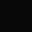

In [21]:
mse_loss = []
l1_loss = []
AbsMeanDelta = []
for i in range(1):
    y_pred = generator(torch.Tensor(transformed_features[:1]))[0].detach().numpy().squeeze()
    mse_loss.append(((y_pred - imgs[0])**2).mean())
    l1_loss.append(abs(y_pred - imgs[0]).mean())
    AbsMeanDelta.append(abs((y_pred - imgs[0]).mean()))
 
print(np.mean(mse_loss))
print(np.mean(l1_loss))
print(np.mean(AbsMeanDelta))
Image.fromarray(abs(y_pred.reshape((32, 32)) * 255).astype(np.uint8))

In [22]:
n_samples = 1000

# getting the predictions for this feature
pred_rings = torch.zeros((n_samples, 1024), dtype=torch.float, device='cpu')
X = torch.Tensor(transformed_features[:1])
with torch.no_grad():
    for j in range(n_samples):
        pred_rings[j] += generator(X)[0].squeeze()

pred_rings = pred_rings.detach().numpy().reshape((n_samples, 32, 32))

pred_ring = pred_rings.mean(axis=0) * 255
true_img = data_gen.ring_from_features(*features[0])
true_ring = true_img * 255

In [23]:
# n_samples = data_gen.kernel.shape[0] // 20

# # getting the predictions for this feature
# true_prob_samples = torch.zeros((n_samples, 32, 32))
# for j in range(n_samples):
#     true_prob_samples[j] += true_img * data_gen.kernel[j].reshape((32, 32))

mean, sig, theta, phi = features[0][2], features[0][3], features[0][4], features[0][5]

true_prob_samples = data_gen.get_noise(1000000, mean, sig, theta, phi)[0, :].numpy()

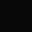

In [24]:
# predicted gaussian ring
Image.fromarray(abs(pred_ring).astype(np.uint8))

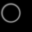

In [25]:
# true gaussian ring
Image.fromarray(true_ring.numpy().astype(np.uint8))

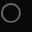

In [26]:
# difference between the rings
Image.fromarray(np.abs(true_ring.numpy() - pred_ring).astype(np.uint8))

In [27]:
# MSE error
((pred_ring / pred_ring.max() - true_ring.numpy() / true_ring.numpy().max())**2).mean()

0.8687409

(21, 11)


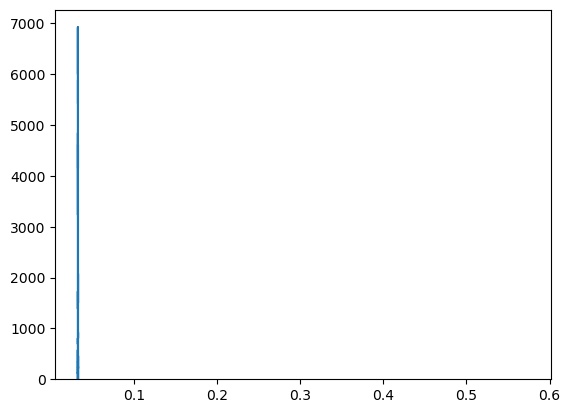

In [28]:
# getting the distribution for one pmt
pmt = (np.random.randint(32), np.random.randint(32))
while true_ring[pmt] < 0.4 * 255:
    pmt = (np.random.randint(32), np.random.randint(32))
print(pmt)

hist_width = 0.001

# predictited distribution
hist, bins = np.histogram(pred_rings[:, pmt[0], pmt[1]], bins=50, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, hist)


# pred = pd.Series(pred_rings[:, pmt[0], pmt[1]])
# hist = pd.Series(1, index=pd.cut(pred, np.arange(0, 1.005, hist_width))).sort_index().groupby(level=0).sum()
# pred_noise = hist / (hist.sum() * hist_width)
# plt.plot(np.arange(0, 1, hist_width), pred_noise)

# true distribution
plt.hist(true_prob_samples + true_ring[pmt].item() / 255, bins=1000, density=True)
plt.show()